In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random

from google.colab.patches import cv2_imshow

from gym import Env, spaces
import time

font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

ModuleNotFoundError: No module named 'google'

In [ ]:
class Object(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def move(self, del_x):
        self.x += del_x
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)
    
class Agent(Object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Agent, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("agent.jpg") / 255.0
        self.icon_w = 64
        self.icon_h = 64
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

    
class Bush(Object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bush, self).__init__(name, x_max, x_min, y_max, y_min)
        self.bush_type = 0
        r = random.random()
        if r<=0.5:
            self.icon = cv2.imread("bush1.png") / 255.0
            self.bush_type = 0
        else:
            self.icon = cv2.imread("bush2.jpg") / 255.0
            self.bush_type = 1
        self.icon_w = 100
        self.icon_h = 100
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

In [ ]:
class Foraging(Env):
    def __init__(self):
        super(Foraging, self).__init__()
        

        
        # Define a 2-D observation space
        self.observation_shape = (600, 800, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = 'float64')
    
    
        self.action_space = spaces.Discrete(2,)
                        
        self.canvas = np.ones(self.observation_shape) * 1
        
        self.elements = []
        
        self.n = 0
        self.elapsed_time = 0
        
        self.interval_time = 10
        self.decision_time = 2
        self.total_time = 240
        
        self.total_rewards  = 0
        self.current_reward = 0

        self.y_min = int (self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int (self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]

    def draw_elements_on_canvas(self): 
        self.canvas = np.ones(self.observation_shape) * 1
        
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon

        text = 'Time Passed: {} | Total Rewards: {} | Current Reward: {}'.format(self.elapsed_time, self.total_rewards, self.current_reward)

        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (0,0,0), 1, cv2.LINE_AA)
        
    def reset_agent(self):
        x_agent = int(self.observation_shape[0] * 0.25) 
        y_agent = int(self.observation_shape[1] * 0.3)
                      
        self.agent = Agent("agent", self.x_max, self.x_min, self.y_max, self.y_min)
        self.agent.set_position(x_agent,y_agent)

    def reset_bush(self):
        x_bush = self.agent.x + int(self.observation_shape[0] * 0.15)
        y_bush = int(self.observation_shape[1] * 0.28)
        
        self.bush = Bush("bush", self.x_max, self.x_min, self.y_max, self.y_min)
        self.bush.set_position(x_bush,y_bush)
    
    def reset(self):
        self.n = 0
        
        self.elapsed_time = 0

        self.total_rewards  = 0
        self.current_reward = 0

        self.reset_agent()
        self.reset_bush()
         
        self.elements = [self.agent, self.bush]

        self.draw_elements_on_canvas()

        return self.canvas 

    def render(self, mode = "human"):
        assert mode in ["human", "human"], "Invalid render mode"
        if mode == "human":
            cv2_imshow(self.canvas)
            cv2.waitKey(1000)

        elif mode == "human":
            return self.canvas

    def close(self):
        cv2.destroyAllWindows()
        
    def get_action_meanings(self):
        return {0: "Leave", 1: "Harvest"}
    
    def seed(self,seed=None) -> None:
        np.random.seed(seed)
        random.seed(seed)

    def step(self, action):
        
        done = False
        assert self.action_space.contains(action), "Invalid Action" 
        self.current_reward = 0      
        
        if action == 1:
            if self.elapsed_time + self.decision_time > self.total_time:
                done=True
            else:
                for i in range(self.decision_time-1):
                    self.elapsed_time += 1
                    # self.draw_elements_on_canvas()
                    # self.render(mode = "human")
                    
                self.elapsed_time += 1
                if self.bush.bush_type == 0:
                    reward_mean = 7
                else: 
                    reward_mean = 15 
                self.current_reward = reward_mean - 0.5*self.n + np.random.normal(0,0.025,1)
                self.total_rewards += self.current_reward
                self.n += 1
                # self.draw_elements_on_canvas()
                # self.render(mode = "human")
                
        elif action == 0:
            if self.elapsed_time + self.interval_time > self.total_time:
                done=True
            else:
                self.n = 0
                self.elapsed_time += 1
                
                self.elements.remove(self.bush)
                # self.draw_elements_on_canvas()
                # self.render(mode = "human")
                
                self.elapsed_time += 1
                
                step_size = int(self.observation_shape[0] * 0.075)
                
                self.bush = Bush("bush", self.x_max, self.x_min, self.y_max, self.y_min)
                bush_x = self.agent.x + step_size + (step_size * (self.interval_time-1))
                bush_y = y_bush = int(self.observation_shape[1] * 0.28)
                self.bush.set_position(bush_x, bush_y)
                self.elements.append(self.bush)
                # self.draw_elements_on_canvas()
                # self.render(mode = "human")
                
                for i in range(self.interval_time-2):
                    self.bush.move(-step_size)
                    self.elapsed_time += 1
                    # self.draw_elements_on_canvas()
                    # self.render(mode = "human")

        if self.elapsed_time == self.total_time:
            done = True

        return self.n, self.current_reward, done, []

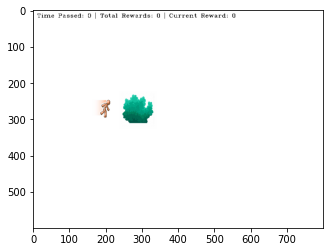

In [ ]:
env = Foraging()
obs = env.reset()
plt.imshow(obs)

In [ ]:
from IPython import display
env = Foraging()
obs = env.reset()
env.seed(42)

e = 0
done = False
env.action_space.seed(37)
total_reward = 0
while not done:
    # Take a random action
    action = env.action_space.sample()
    e = e+1
    total_reward += reward
    obs, reward, done, info = env.step(action)
    print(f"State: {obs} | Reward: {reward}")

env.close()

State: 0 | Reward: 0
State: 1 | Reward: [15.01241785]
State: 2 | Reward: [14.49654339]
State: 3 | Reward: [14.01619221]
State: 4 | Reward: [13.53807575]
State: 0 | Reward: 0
State: 1 | Reward: [6.99414617]
State: 0 | Reward: 0
State: 0 | Reward: 0
State: 1 | Reward: [6.99414658]
State: 2 | Reward: [6.53948032]
State: 0 | Reward: 0
State: 1 | Reward: [15.01918587]
State: 2 | Reward: [14.48826314]
State: 0 | Reward: 0
State: 1 | Reward: [15.013564]
State: 2 | Reward: [14.48841456]
State: 0 | Reward: 0
State: 0 | Reward: 0
State: 0 | Reward: 0
State: 1 | Reward: [6.98835676]
State: 2 | Reward: [6.50604906]
State: 0 | Reward: 0
State: 0 | Reward: 0
State: 0 | Reward: 0
State: 0 | Reward: 0
State: 0 | Reward: 0
State: 0 | Reward: 0
State: 1 | Reward: [14.95216799]
State: 0 | Reward: 0
State: 1 | Reward: [14.95687705]
State: 2 | Reward: [14.48594281]
State: 0 | Reward: 0
State: 1 | Reward: [6.97467922]
State: 2 | Reward: [6.50785618]
State: 0 | Reward: 0
State: 1 | Reward: [14.9772994]
State

In [ ]:
total_reward

array([281.566915])

In [ ]:
ac = [0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0]

In [ ]:
action_list==ac

True